# Proyecto Final

## Downloading data

In [1]:
import pandas as pd
import sys
import time
import numpy as np
from random import shuffle, random, sample, randint, randrange, uniform
from copy import deepcopy
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from itertools import combinations

In [2]:
candidatos = pd.read_excel("Candidatos_supermercados.xlsx")

In [3]:
candidatos.head()

,ID,Descripcion,Latitud,Longitud,Poblacion500m
0,Punto 1,Esq. Benavides con Nicolas Dueñas,-12.04861,-77.06496,16500
1,Ponto 2,Sta Bernardita con Republica de Venezuela,-12.05956,-77.07583,18000
2,Ponto 3,Santa Susana con Santa Gertrudis,-12.06524,-77.07334,17000
3,Ponto 4,Belizario Sosa Pelaez,-12.05998,-77.06300,15000
4,Ponto 5,Esq. Aurelio Garcia y Miranono Arredondo,-12.05541,-77.07497,17100


In [4]:
class Item(object):
    def __init__(self, latitud, longitud, poblacion):
        self.latitud = latitud
        self.longitud = longitud
        self.poblacion = poblacion

In [5]:
ItemPool = []
for i in range(len(candidatos)):
    latitud = candidatos.iloc[i]["Latitud"]
    longitud = candidatos.iloc[i]["Longitud"]
    poblacion = candidatos.iloc[i]["Poblacion500m"]
    ItemPool.append(Item(latitud, longitud, poblacion))

In [6]:
def replace_char(text, pos, char_replaced):
    list1 = list(text)
    list1[pos] = char_replaced
    text = "".join(list1)
    return text


def get_distance_between_stores(item_1, item_2):
    x_dist = (item_2.longitud - item_1.longitud) ** 2
    y_dist = (item_2.latitud - item_1.latitud) ** 2
    return (x_dist + y_dist) ** (1 / 2)

In [7]:
class Individual:
    def __init__(self, chromosome):  # el constructor recibe un cromosoma
        self.chromosome = chromosome[:]
        self.chromosome = "".join(list(map(str, self.chromosome)))
        self.fitness = -1  # -1 indica que el individuo no ha sido evaluado

    def crossover_onepoint(self, other):
        "Retorna dos nuevos individuos del cruzamiento de un punto entre individuos self y other"
        c = randrange(len(self.chromosome))
        ind1 = Individual(self.chromosome[:c] + other.chromosome[c:])
        ind2 = Individual(other.chromosome[:c] + self.chromosome[c:])
        return [ind1, ind2]

    def crossover_uniform(self, other):
        chromosome1 = []
        chromosome2 = []
        "Retorna dos nuevos individuos del cruzamiento uniforme entre self y other "
        for i in range(len(self.chromosome)):
            if uniform(0, 1) < 0.5:
                chromosome1.append(self.chromosome[i])
                chromosome2.append(other.chromosome[i])
            else:
                chromosome1.append(other.chromosome[i])
                chromosome2.append(self.chromosome[i])
        ind1 = Individual(chromosome1)
        ind2 = Individual(chromosome2)
        return [ind1, ind2]

    def mutation_flip(self):
        "Cambia aleatoriamente el alelo de un gen."
        new_chromosome = deepcopy(self.chromosome)
        mutGene = randrange(0, len(new_chromosome))  # escoge un gen para mutar
        if new_chromosome[mutGene] == "0":
            # new_chromosome[mutGene] = '1'
            replace_char(new_chromosome, mutGene, "1")
        else:
            # new_chromosome[mutGene] = '0'
            replace_char(new_chromosome, mutGene, "0")
        return Individual(new_chromosome)

    def poblacion(self, ItemPool=ItemPool):
        poblacion = 0
        for i in range(len(self.chromosome)):
            if self.chromosome[i] == "1":
                poblacion += ItemPool[i].poblacion
        return poblacion

    def distancia(self, ItemPool=ItemPool):
        items_presents = []
        distancia = 0
        for i in range(len(self.chromosome)):
            if self.chromosome[i] == "1":
                items_presents.append(ItemPool[i])

        for item_1, item_2 in combinations(items_presents, 2):
            distancia += get_distance_between_stores(item_1, item_2)

        return distancia

    def graph_indi(self, ItemPool=ItemPool):
        count = 0
        items_presents = []
        fig = plt.figure()
        for i in range(len(self.chromosome)):
            if self.chromosome[i] == "1":
                count += 1
                items_presents.append(ItemPool[i])

        latitudes = [item.latitud for item in items_presents]
        longitudes = [item.longitud for item in items_presents]
        plt.scatter(longitudes, latitudes)
        plt.title(
            f"Poblacion = {self.poblacion(ItemPool)}, Distancia = {round(self.distancia(ItemPool),4)}"
        )
        plt.xlabel('Longitud °')
        plt.ylabel('Latitud °')
        plt.show()
        plt.close()

In [ ]:
## Hiperparametros del algoritmo genetico

NUM_ITEMS = 60  # numero de items

MAX_TIENDAS = 10  # maximo peso que puede soportar la mochila

POP_SIZE = 100
MIN_POP_SIZE = 100
MAX_POP_SIZE = 100
CHROMOSOME_SIZE = NUM_ITEMS
GENERATIONS = 500  # numero de generaciones
PMUT = 0.9  # tasa de mutacion

## Mono-Objectivos
En esta sección se establecen las clases que usaremos.
Por facilidad, se ha convertido los algoritmos monoobjectivos en una sola clase llamada `monobjective`.

In [9]:
class monobjective:
    def __init__(
        self,
        pmut_=0.1,
        popsize_=100,
        generations_=GENERATIONS,
        crossover_="uniform",
        selection_method_="tournament",
        mutation_="flip",
        verbose=True,
        weight_pop=1.5,
        graph=True,
    ):
        self.PMUT = pmut_  # taza de mutacion
        self.POPSIZE = popsize_  # numero de individuos
        self.GENERATIONS = generations_  # numero de generaciones
        self.CROSSOVER = crossover_
        self.SELECTION_METHOD = selection_method_
        self.MUTATION = mutation_
        self.verbose = verbose
        self.weight_pop = weight_pop
        self.graph = graph

    def get_fitness(self, chromosome, items, max_items):
        """Retorna el fitness del cromosoma pasado. Fitness es el valor total de los items incluidos en el cromosoma
        Si el peso total es mayor que max_weight -> el fitness es 1"""
        fitness = 0  # initialize fitness to 0
        poblacion = 0
        distancia = 0
        cont = 0

        ITEMS_from_chromosome_ = []
        for i in range(NUM_ITEMS):
            if chromosome[i] == "1":
                cont += 1
                ITEMS_from_chromosome_.append(ItemPool[i])

        poblacion = np.sum([item.poblacion for item in ITEMS_from_chromosome_])

        for item_1, item_2 in combinations(ITEMS_from_chromosome_, 2):
            distancia += get_distance_between_stores(item_1, item_2)

        if cont > max_items:
            return 0

        return poblacion / 1e5 * self.weight_pop + distancia

    def evaluate_population(self, population, items, max_weight):
        """Evalua una poblacion de individuos con la funcion get_fitness"""
        popsize = len(population)
        for i in range(popsize):
            if (
                population[i].fitness == -1
            ):  # evalua solo si el individuo no esta evaluado
                population[i].fitness = self.get_fitness(
                    population[i].chromosome, items, max_weight
                )

    def init_population(self, pop_size, chromosome_size):
        # Inicializa una poblacion de pop_size individuos, cada cromosoma de individuo de tamaño chromosome_size.
        population = []
        for i in range(pop_size):
            new_chromosome = np.zeros(chromosome_size)
            # ones = randint(MAX_TIENDAS/5, MAX_TIENDAS)
            ones = 10
            new_chromosome[0:ones] = 1
            np.random.shuffle(new_chromosome)
            new_chromosome = np.array(list(map(int, new_chromosome)))
            population.append(Individual(new_chromosome))
        return population

    def select_parents_roulette(self, population):
        popsize = len(population)

        # Escoje el primer padre
        sumfitness = sum(
            [indiv.fitness for indiv in population]
        )  # suma total del fitness de la poblacion
        pickfitness = uniform(
            0, sumfitness
        )  # escoge un numero aleatorio entre 0 y sumfitness
        cumfitness = 0  # fitness acumulado
        for i in range(popsize):
            cumfitness += population[i].fitness
            if cumfitness > pickfitness:
                iParent1 = i
                break

        # Escoje el segundo padre, desconsiderando el primer padre
        sumfitness = (
            sumfitness - population[iParent1].fitness
        )  # retira el fitness del padre ya escogido
        pickfitness = uniform(
            0, sumfitness
        )  # escoge un numero aleatorio entre 0 y sumfitness
        cumfitness = 0  # fitness acumulado
        for i in range(popsize):
            if i == iParent1:
                continue  # si es el primer padre
            cumfitness += population[i].fitness
            if cumfitness > pickfitness:
                iParent2 = i
                break
        return (population[iParent1], population[iParent2])

    def select_parents_tournament(self, population, tournament_size):
        # Escoje el primer padre
        list_indiv = []
        x1 = np.random.permutation(len(population))
        y1 = x1[0:tournament_size]
        for i in range(tournament_size):
            list_indiv.append(population[y1[i]].fitness)

        iParent1 = np.argmax(list_indiv)

        # Escoje el segundo padre, desconsiderando el primer padre
        x2 = np.delete(x1, iParent1)
        x2 = np.random.permutation(x2)
        list_indiv = []
        y2 = x2[0:tournament_size]
        for i in range(tournament_size):
            list_indiv.append(population[y2[i]].fitness)
        iParent2 = np.argmax(list_indiv)

        return (population[x1[iParent1]], population[x2[iParent2]])

    def select_survivors_ranking(self, population, offspring_population, numsurvivors):
        next_population = []
        population.extend(offspring_population)  # une las dos poblaciones
        isurvivors = sorted(
            range(len(population)), key=lambda i: population[i].fitness, reverse=True
        )[:numsurvivors]
        for i in range(numsurvivors):
            next_population.append(population[isurvivors[i]])
        return next_population

    def genetic_algorithm(
        self,
        poblacion_inicial,
        items,
        max_weight,
        ngen=100,
        pmut=0.1,
        crossover="onepoint",
        mutation="flip",
        selection_parents_method="roulette",
        selection_survivors_method="ranking",
    ):
        """Algoritmo Genetico para el problema de la mochila
        items:      pool de items a escoger para la mochila.
                    Debe ser una lista de objetos de clase Item
        max_weight: maximo peso que puede soportar la mochila
        ngen:       maximo numero de generaciones
        pmut:       tasa de mutacion
        crossover:  operador de cruzamiento
        mutation:   operador de mutacion
        selection_parents_method: método de selección de padres para cruzamiento
        selection_survivors_method: método de selección de sobrevivientes
        """

        population = deepcopy(
            poblacion_inicial
        )  # copia la poblacion inicial en una nueva variable para no alterar la inicial

        popsize = len(population)
        self.evaluate_population(
            population, items, max_weight
        )  # evalua la poblacion inicial
        ibest = sorted(
            range(len(population)), key=lambda i: population[i].fitness, reverse=True
        )[
            :1
        ]  # mejor individuo
        bestfitness = [population[ibest[0]].fitness]  # fitness del mejor individuo
        if self.verbose == True:
            print(
                "Poblacion inicial, best_fitness = {}".format(
                    population[ibest[0]].fitness
                )
            )

        for g in range(ngen):  # Por cada generacion

            ## Selecciona parejas de individuos (mating_pool) para cruzamiento con el metodo de la ruleta
            mating_pool = []
            for i in range(int(popsize / 2)):
                if selection_parents_method == "roulette":
                    mating_pool.append(self.select_parents_roulette(population))
                elif selection_parents_method == "tournament":
                    mating_pool.append(self.select_parents_tournament(population, 3))
                else:
                    raise NotImplementedError
            ## Crea la poblacion descendencia cruzando las parejas del mating pool
            offspring_population = []
            for i in range(len(mating_pool)):
                if crossover == "onepoint":
                    offspring_population.extend(
                        mating_pool[i][0].crossover_onepoint(mating_pool[i][1])
                    )  # cruzamiento 1 punto
                elif crossover == "uniform":
                    offspring_population.extend(
                        mating_pool[i][0].crossover_uniform(mating_pool[i][1])
                    )  # cruzamiento uniforme
                else:
                    raise NotImplementedError

            ## Aplica el operador de mutacion con probabilidad pmut en cada hijo generado
            for i in range(len(offspring_population)):
                if uniform(0, 1) < pmut:
                    if mutation == "flip":
                        offspring_population[i] = offspring_population[
                            i
                        ].mutation_flip()  # cambia el alelo de un gen
                    elif mutation == "inversion":
                        offspring_population[i] = offspring_population[
                            i
                        ].mutation_inversion()  # invierte todos los genes entre 2 puntos al azar
                    elif mutation == "multiflip":
                        offspring_population[i] = offspring_population[
                            i
                        ].mutation_multiflip()  # invierte N genes del cromosoma, donde N es menor o igual al 50% de la longitud del cromosoma
                    else:
                        raise NotImplementedError

            ## Evalua la poblacion descendencia creada
            self.evaluate_population(
                offspring_population, items, max_weight
            )  # evalua la poblacion descendencia

            ## Selecciona individuos para la sgte. generación
            if selection_survivors_method == "ranking":
                population = self.select_survivors_ranking(
                    population, offspring_population, popsize
                )  # metodo de ranking
            else:
                raise NotImplementedError

            ## Almacena la historia del fitness del mejor individuo
            ibest = sorted(
                range(len(population)),
                key=lambda i: population[i].fitness,
                reverse=True,
            )[:1]
            bestfitness.append(population[ibest[0]].fitness)

            if self.verbose == True:
                if g % 10 == 0:  # muestra resultados cada 10 generaciones
                    print(
                        "generacion {}, (Mejor fitness = {})".format(
                            g, population[ibest[0]].fitness
                        )
                    )
        if self.verbose == True:
            print(
                "Mejor individuo en la ultima generacion = {} (fitness = {})".format(
                    population[ibest[0]].chromosome, population[ibest[0]].fitness
                )
            )
        return (
            population[ibest[0]],
            bestfitness,
        )  # devuelve el mejor individuo y la lista de mejores fitness x gen

    def run_best_solution_monobjective(self):
        poblacion_inicial = self.init_population(self.POPSIZE, NUM_ITEMS)

        best_ind, bestfitness = self.genetic_algorithm(
            poblacion_inicial,
            ItemPool,
            MAX_TIENDAS,
            self.GENERATIONS,
            self.PMUT,
            crossover=self.CROSSOVER,
            mutation=self.MUTATION,
            selection_parents_method=self.SELECTION_METHOD,
            selection_survivors_method="ranking",
        )
        if self.graph == True:
            best_ind.graph_indi(ItemPool)
        return best_ind, bestfitness

### Probando
Se corre el algoritmo 10 veces.
Cada vez que se corre, se crea una población nueva.

Los resultados muestran que el algoritmo coloca a las tiendas con una `distancia promedio` de `4.83° +/- 0.07` y una `población promedio` de `142280 +/- 2677`. Hay que recordar que esta solución es para los específicos pesos que se han asignado (mirar fitness). 

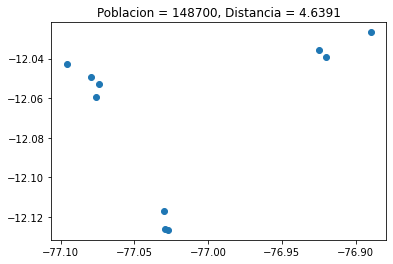

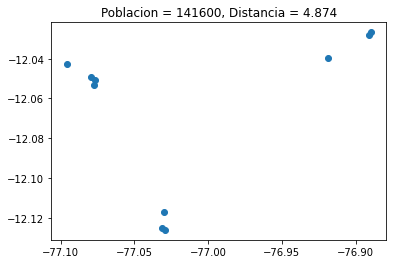

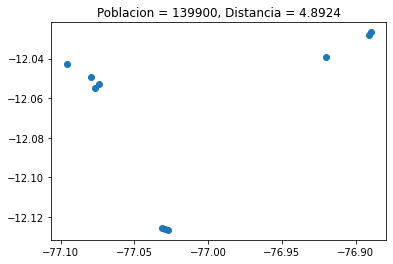

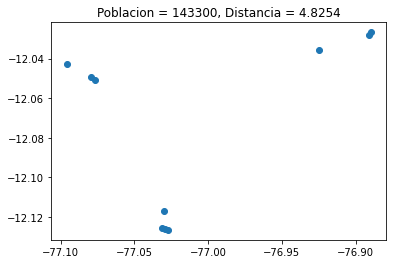

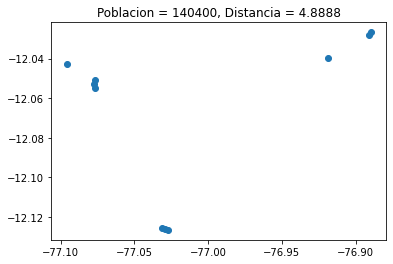

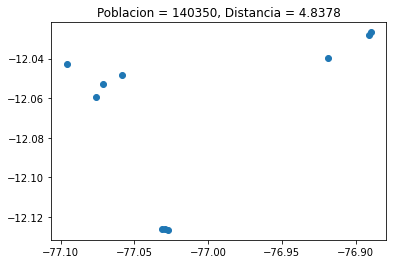

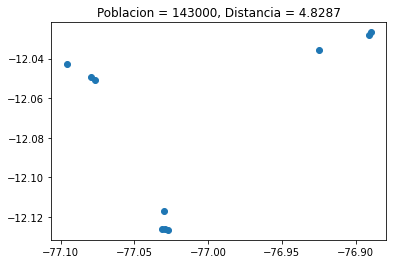

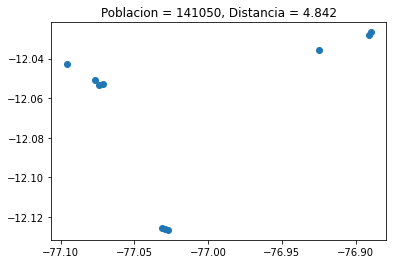

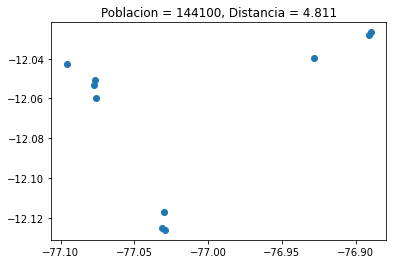

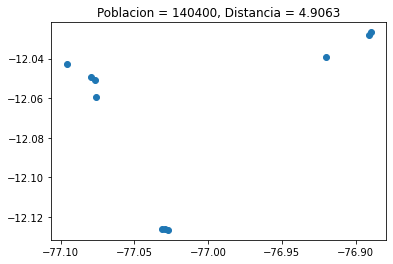

In [10]:

data_mono = []
for i in range(10):
    mono = monobjective(verbose=False, weight_pop=2.5)
    best_ind, bestfitness = mono.run_best_solution_monobjective()
    data_mono.append([i, best_ind.poblacion(), best_ind.distancia()])

In [11]:
results_mono = pd.DataFrame(data_mono, columns=["Trial", "Poblacion", "Distancia"])

In [12]:
results_mono

,Trial,Poblacion,Distancia
0,0,148700,4.639124
1,1,141600,4.874047
2,2,139900,4.892417
3,3,143300,4.825402
4,4,140400,4.888805
5,5,140350,4.837832
6,6,143000,4.828719
7,7,141050,4.842017
8,8,144100,4.811009
9,9,140400,4.906275


In [13]:
results_mono.mean()

Trial             4.500000
Poblacion    142280.000000
Distancia         4.834565
dtype: float64

In [14]:
results_mono.std()

Trial           3.027650
Poblacion    2677.498833
Distancia       0.075958
dtype: float64

## MultiObjectivos

In [15]:
class multiobjective:
    def __init__(self, verbose=False):
        self.PMUT = 0.9  # tasa de mutacion
        self.verbose = verbose

    def get_fitness(self, chromosome, items, max_items):
        """Retorna los fitness del cromosoma pasado [valor_de_la_mochila, ligereza]"""
        fitness = np.zeros(
            2
        )  # 2 objetivos, fitness[0] es valor, fitness[1] es 1/peso (ligereza)
        poblacion = 0
        distancia = 0
        cont = 0

        ITEMS_from_chromosome_ = []
        for i in range(NUM_ITEMS):
            if chromosome[i] == "1":
                cont += 1
                ITEMS_from_chromosome_.append(ItemPool[i])

        poblacion = np.sum([item.poblacion for item in ITEMS_from_chromosome_])

        for item_1, item_2 in combinations(ITEMS_from_chromosome_, 2):
            distancia += get_distance_between_stores(item_1, item_2)

        if cont > max_items:
            fitness[0] = 0.5
            fitness[1] = 0.5
        else:
            fitness[0] = poblacion
            fitness[1] = distancia

        return fitness

    def init_population(self, pop_size, chromosome_size):
        # Inicializa una poblacion de pop_size individuos, cada cromosoma de individuo de tamaño chromosome_size.
        population = []
        for i in range(pop_size):
            new_chromosome = np.zeros(chromosome_size)
            # ones = randint(MAX_TIENDAS/5, MAX_TIENDAS)
            ones = 10
            new_chromosome[0:ones] = 1
            np.random.shuffle(new_chromosome)
            new_chromosome = np.array(list(map(int, new_chromosome)))
            population.append(Individual(new_chromosome))
        return population

    def evaluate_population(self, population, items, max_weight):
        """Evalua una poblacion de individuos con la funcion get_fitness"""
        pop_size = len(population)

        for i in range(pop_size):
            if (
                population[i].fitness == -1
            ):  # evalua solo si el individuo no esta evaluado
                population[i].fitness = self.get_fitness(
                    population[i].chromosome, items, max_weight
                )

    def build_offspring_population(self, population, crossover, mutation, pmut):
        """Construye una poblacion hija con los operadores de cruzamiento y mutacion pasados
        crossover:  operador de cruzamiento
        mutation:   operador de mutacion
        pmut:       taza de mutacion
        """
        pop_size = len(population)

        ## Selecciona parejas de individuos (mating_pool) para cruzamiento

        mating_pool = []
        for i in range(int(pop_size / 2)):
            # escoje dos individuos diferentes aleatoriamente de la poblacion
            permut = np.random.permutation(pop_size)
            mating_pool.append((population[permut[0]], population[permut[1]]))

        ## Crea la poblacion descendencia cruzando las parejas del mating pool
        offspring_population = []
        for i in range(len(mating_pool)):
            if crossover == "onepoint":
                offspring_population.extend(
                    mating_pool[i][0].crossover_onepoint(mating_pool[i][1])
                )  # cruzamiento 1 punto
            elif crossover == "uniform":
                offspring_population.extend(
                    mating_pool[i][0].crossover_uniform(mating_pool[i][1])
                )  # cruzamiento uniforme
            else:
                raise NotImplementedError

        ## Aplica el operador de mutacion con probabilidad pmut en cada hijo generado
        for i in range(len(offspring_population)):
            if uniform(0, 1) < pmut:
                if mutation == "flip":
                    offspring_population[i] = offspring_population[
                        i
                    ].mutation_flip()  # cambia el alelo de un gen
                else:
                    raise NotImplementedError

        return offspring_population

    def get_crowding_distances(self, fitnesses):
        """
        La distancia crowding de un individuo es la diferencia del fitness mas proximo hacia arriba menos el fitness mas proximo
        hacia abajo. El valor crowding total es la suma de todas las distancias crowdings para todos los fitness
        """

        pop_size = len(fitnesses[:, 0])
        num_objectives = len(fitnesses[0, :])

        # crea matriz crowding. Filas representan individuos, columnas representan objectives
        crowding_matrix = np.zeros((pop_size, num_objectives))

        # normalisa los fitnesses entre 0 y 1 (ptp es max - min)
        normalized_fitnesses = (fitnesses - fitnesses.min(0)) / fitnesses.ptp(0)

        for col in range(num_objectives):  # Por cada objective
            crowding = np.zeros(pop_size)

            # puntos extremos tienen maximo crowding
            crowding[0] = 1
            crowding[pop_size - 1] = 1

            # ordena los fitness normalizados del objectivo actual
            sorted_fitnesses = np.sort(normalized_fitnesses[:, col])
            sorted_fitnesses_index = np.argsort(normalized_fitnesses[:, col])

            # Calcula la distancia crowding de cada individuo como la diferencia de score de los vecinos
            crowding[1 : pop_size - 1] = (
                sorted_fitnesses[2:pop_size] - sorted_fitnesses[0 : pop_size - 2]
            )

            # obtiene el ordenamiento original
            re_sort_order = np.argsort(sorted_fitnesses_index)
            sorted_crowding = crowding[re_sort_order]

            # Salva las distancias crowdingpara el objetivo que se esta iterando
            crowding_matrix[:, col] = sorted_crowding

        # Obtiene las distancias crowding finales sumando las distancias crowding de cada objetivo
        crowding_distances = np.sum(crowding_matrix, axis=1)

        return crowding_distances

    def select_by_crowding(self, population, num_individuals):
        """
        Selecciona una poblacion de individuos basado en torneos de pares de individuos: dos individuos se escoge al azar
        y se selecciona el mejor segun la distancia crowding. Se repite hasta obtener num_individuals individuos
        """
        population = deepcopy(population)
        pop_size = len(population)

        num_objectives = len(population[0].fitness)

        # extrae los fitness de la poblacion en la matriz fitnesses
        fitnesses = np.zeros([pop_size, num_objectives])
        for i in range(pop_size):
            fitnesses[i, :] = population[i].fitness

        # obtiene las  distancias  crowding
        crowding_distances = self.get_crowding_distances(fitnesses)

        population_selected = []  # poblacion escogida

        for i in range(num_individuals):  # por cada individuo a seleccionar

            # escoje dos individuos aleatoriamente de la poblacion no escogida aun
            permut = np.random.permutation(len(population))
            ind1_id = permut[0]
            ind2_id = permut[1]

            # Si ind1_id es el mejor
            if crowding_distances[ind1_id] >= crowding_distances[ind2_id]:

                # traslada el individuo ind1 de population a la lista de individuos seleccionados
                population_selected.append(population.pop(ind1_id))
                # remueve la distancia crowding del individuo seleccionado
                crowding_distances = np.delete(crowding_distances, ind1_id, axis=0)

            else:  # Si ind2_id es el mejor

                # traslada el individuo ind2 de population a la lista de individuos seleccionados
                population_selected.append(population.pop(ind2_id))
                # remueve la distancia crowding del individuo seleccionado
                crowding_distances = np.delete(crowding_distances, ind2_id, axis=0)

        return population_selected

    def get_paretofront_population(self, population):
        """
        Obtiene de population la poblacion de individups de la frontera de Pareto,
        """
        population = deepcopy(population)
        pop_size = len(population)

        # todos los individuos son inicialmente asumidos como la frontera de Pareto
        pareto_front = np.ones(pop_size, dtype=bool)

        for i in range(pop_size):  # Compara cada individuo contra todos los demas
            for j in range(pop_size):
                # Chequea si individuo 'i' es dominado por individuo 'j'
                # if all(population[j].fitness >= population[i].fitness) and any(population[j].fitness > population[i].fitness):
                # if str(all(population[j].fitness >= population[i].fitness)) and str(any(population[j].fitness > population[i].fitness)):
                if all(
                    np.asarray(population[j].fitness)
                    >= np.asarray(population[i].fitness)
                ) and any(
                    np.asarray(population[j].fitness)
                    > np.asarray(population[i].fitness)
                ):
                    # j domina i -> señaliza que individuo 'i' como no siendo parte de la frontera de Pareto
                    pareto_front[i] = 0
                    break  # Para la busqueda para 'i' (no es necesario hacer mas comparaciones)

        paretofront_population = []
        for i in range(
            pop_size
        ):  # construye la lista de individuos de la frontera de Pareto
            if pareto_front[i] == 1:
                paretofront_population.append(population[i])

        return paretofront_population

    def build_next_population(self, population, min_pop_size, max_pop_size):
        """
        Construye la poblacion de la siguiente generacion añadiendo sucesivas fronteras de Pareto hasta
        tener una poblacion de al menos min_pop_size individuos. Reduce la frontera de Pareto con el metodo de
        crowding distance si al agregar la frontera excede el tamaño maximo de la poblacion (max_pop_size)
        """
        population = deepcopy(population)
        pareto_front = []
        next_population = []

        while (
            len(next_population) < min_pop_size
        ):  # mientras la poblacion no tenga el tamaño minimo
            # obtiene la poblacion frontera de Pareto actual
            paretofront_population = self.get_paretofront_population(population)

            # si poblacion actual + paretofront excede el maximo permitido -> reduce paretofront con el metodo de crowding
            combined_population_size = len(next_population) + len(
                paretofront_population
            )
            if combined_population_size > max_pop_size:
                paretofront_population = self.select_by_crowding(
                    paretofront_population, max_pop_size - len(next_population)
                )

            # Adiciona la frontera de Pareto (original o reducida) a la poblacion en construccion
            next_population.extend(paretofront_population)

            # remueve de population los individuos que fueron agregados a next_population
            for i in range(len(paretofront_population)):
                for j in range(len(population)):
                    array_i = np.asarray(
                        [int(p) for p in paretofront_population[i].chromosome]
                    )
                    array_j = np.asarray(
                        [int(p) for p in paretofront_population[j].chromosome]
                    )
                    if all(array_i == array_j):
                        del population[j]
                        break

        return next_population

    def run_pareto(self):
        # Crea  una poblacion inicial
        poblacion_inicial = self.init_population(MAX_POP_SIZE, NUM_ITEMS)

        P = deepcopy(poblacion_inicial)

        #  evalua la poblacion inicial
        self.evaluate_population(P, ItemPool, MAX_TIENDAS)

        ## Ejecuta los ciclos evolutivos
        for g in tqdm(range(GENERATIONS)):  # Por cada generacion
            if self.verbose == True:
                if g % 10 == 0:
                    print("Generacion {} (de {}) ".format(g, GENERATIONS))

            ## genera y evalua la poblacion hija
            Q = self.build_offspring_population(P, "uniform", "flip", self.PMUT)
            self.evaluate_population(Q, ItemPool, MAX_TIENDAS)

            ## une la poblacion padre y la poblacion hija
            P.extend(Q)

            ## Construye la poblacion de la siguiente generacion
            P = self.build_next_population(P, MIN_POP_SIZE, MAX_POP_SIZE)

        # Obtiene la poblacion de la frontera de pareto final
        pareto_front_population = self.get_paretofront_population(P)

        ## Plotea los individuos de la frontera de Pareto final
        pop_size = len(pareto_front_population)
        num_objectives = len(pareto_front_population[0].fitness)

        # extrae los fitness de la poblacion en la matriz fitnesses
        fitnesses = np.zeros([pop_size, num_objectives])
        for i in range(pop_size):
            fitnesses[i, :] = pareto_front_population[i].fitness

        return fitnesses, pareto_front_population

### Probando

Se muetra los resultados de la clase multiobjectivos junto con los valores de monoobjectivo previamente obtenidos.
Se aprecia que las soluciones mono son parte del límite de pareto. 

  0%|          | 0/500 [00:00<?, ?it/s]

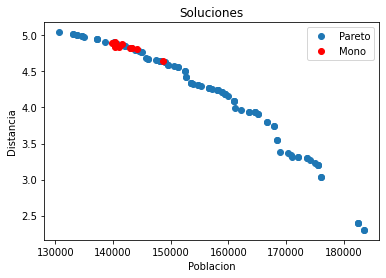

In [16]:
multiobjective_ = multiobjective()
fitness_pareto, pareto_population = multiobjective_.run_pareto()

x1_pareto = fitness_pareto[:, 0]
y1_pareto = fitness_pareto[:, 1]

plt.plot(x1_pareto, y1_pareto, "o", label="Pareto")
plt.plot(results_mono["Poblacion"], results_mono["Distancia"], "or", label="Mono")
plt.xlabel('Poblacion')
plt.ylabel('Distancia')
plt.title('Soluciones')
plt.legend()
plt.show()

## Varias iteraciones

En este caso, cambiamos el peso que tenía asignado la variable población en el algoritmo monoobjectivo, por lo que tendremos distintos resultados. Se aprecia que mientras más peso, la población aumenta, y la distancia disminuye.

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

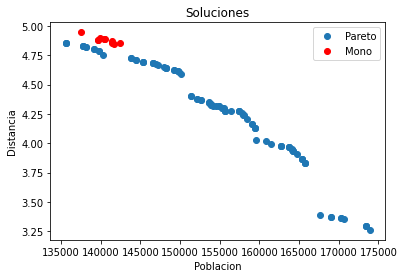

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

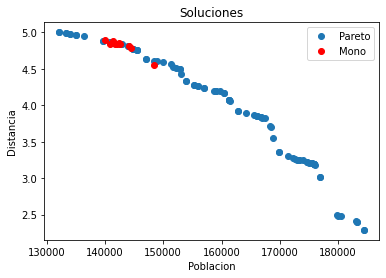

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

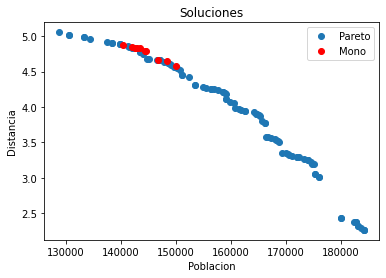

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

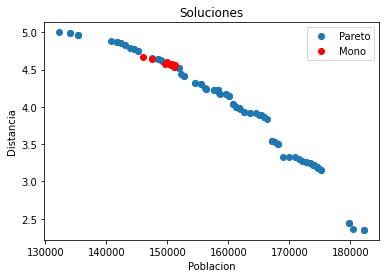

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

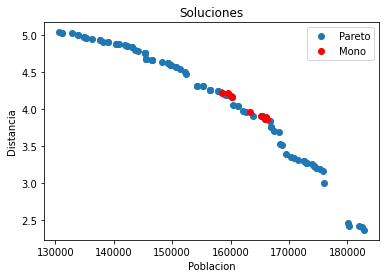

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

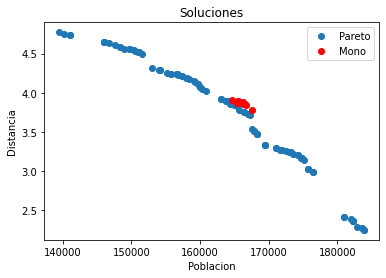

In [17]:
for weight_pop_ in tqdm([2.0, 2.5, 3, 4, 5, 6]):
    data_mono = []
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)
    for i in tqdm(range(10)):
        mono = monobjective(verbose=False, graph=False, weight_pop=weight_pop_)
        best_ind, bestfitness = mono.run_best_solution_monobjective()
        data_mono.append([i, best_ind.poblacion(), best_ind.distancia()])

    results_mono = pd.DataFrame(data_mono, columns=["Trial", "Poblacion", "Distancia"])

    multiobjective_ = multiobjective()
    fitness_pareto, pareto_population = multiobjective_.run_pareto()

    x1_pareto = fitness_pareto[:, 0]
    y1_pareto = fitness_pareto[:, 1]
    ax.plot(x1_pareto, y1_pareto, "o", label="Pareto")
    ax.plot(results_mono["Poblacion"], results_mono["Distancia"], "or", label="Mono")
    plt.legend()
    plt.title(f"Population's weight: {weight_pop_}")
    plt.xlabel('Poblacion')
    plt.ylabel('Distancia')
    plt.title('Soluciones')
    plt.show()
    plt.cla()
    plt.clf()
    plt.close()